## PRE-PROCESSING

### Importing necessary libraries

In [ ]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator


### ZIP File extraction

In [ ]:
# Path to the main zip file
zip_file_path = '/Users/sumanthoruganti/Desktop/DL Mini_Project/archive.zip'
# Absolute path for dataset extraction
dataset_dir = '/Users/sumanthoruganti/Desktop/DL Mini_Project/dataset/'

In [ ]:
# Ensure the extraction directory exists
os.makedirs(dataset_dir, exist_ok=True)

In [ ]:
# Unzip the main archive.zip file
with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall(dataset_dir)
print(f"All files extracted to: {dataset_dir}")

All files extracted to: /Users/sumanthoruganti/Desktop/DL Mini_Project/dataset/


In [ ]:
# Verify extraction by listing files
if os.path.exists(dataset_dir):
    extracted_folders = os.listdir(dataset_dir)
    print("Extracted files and folders:", extracted_folders)
else:
    raise FileNotFoundError(f"Directory '{dataset_dir}' not found.")

Extracted files and folders: ['Mild DR', 'Healthy', 'Moderate DR', 'Severe DR', 'Proliferate DR']


In [ ]:
# Check class distribution and count the number of images in each class
class_names = ['Healthy', 'Mild DR', 'Moderate DR', 'Severe DR', 'Proliferate DR']
class_counts = {}

for class_label in class_names:
    class_path = os.path.join(dataset_dir, class_label)

    if os.path.exists(class_path):
        class_counts[class_label] = len(os.listdir(class_path))
    else:
        print(f"Warning: Class directory '{class_label}' not found in dataset.")


### Histogram(Representing number of images in each class)

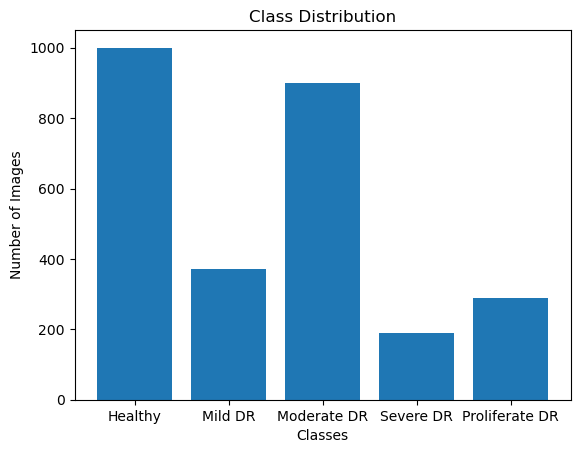

In [ ]:
if class_counts:
    plt.bar(class_counts.keys(), class_counts.values())
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.title('Class Distribution')
    plt.show()

### The images are resized, normalized, and augmented using ImageDataGenerator

In [ ]:
# Create ImageDataGenerator with a 20% validation split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,                    # Normalize pixel values
    rotation_range=30,                 # Rotate images randomly up to 20 degrees
    width_shift_range=0.2,             # Shift images horizontally (up to 10%)
    height_shift_range=0.2,            # Shift images vertically (up to 10%)
    zoom_range=0.3,                    # Randomly zoom images
    horizontal_flip=True,              # Randomly flip images horizontally
    validation_split=0.2,               # Use 20% of data for validation
    brightness_range=[0.8, 1.2],
    shear_range=0.2,
)

In [ ]:
# Flow from directory method: automatically labels images based on folder name
train_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),            # Resize images to 224x224 pixels
    batch_size=32,                     # Load images in batches of 32
    class_mode='categorical',          # 5-class classification
    subset='training'
)

Found 2200 images belonging to 5 classes.


In [ ]:
validation_generator = train_datagen.flow_from_directory(
    dataset_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 550 images belonging to 5 classes.


### Class Weights

In [ ]:
from sklearn.utils import class_weight
import matplotlib.image as mpimg

# Extract the class indices
class_indices = train_generator.class_indices
print("Class indices:", class_indices)

# Compute the class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

class_weights_dict = dict(enumerate(class_weights))
print("Calculated class weights:", class_weights_dict)

Class indices: {'Healthy': 0, 'Mild DR': 1, 'Moderate DR': 2, 'Proliferate DR': 3, 'Severe DR': 4}
Calculated class weights: {0: 0.55, 1: 1.4864864864864864, 2: 0.6111111111111112, 3: 1.896551724137931, 4: 2.8947368421052633}


### Displaying image from each class

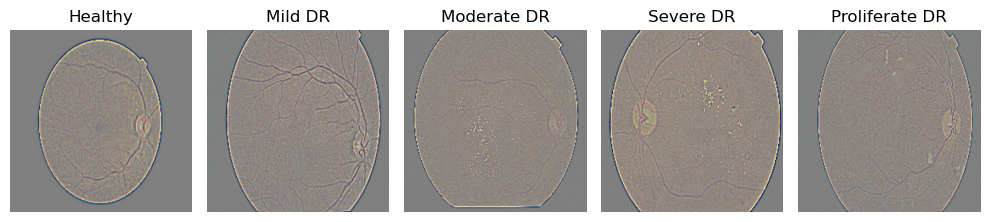

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define the class names
class_names = ['Healthy', 'Mild DR', 'Moderate DR', 'Severe DR', 'Proliferate DR']

# Plotting images from each class
plt.figure(figsize=(10, 10))

for i, class_name in enumerate(class_names):
    class_dir = os.path.join(dataset_dir, class_name)

    if os.path.exists(class_dir) and os.path.isdir(class_dir):
        # Get the first image file from the class folder
        img_name = os.listdir(class_dir)[0]
        img_path = os.path.join(class_dir, img_name)

        # Load and display the image
        img = mpimg.imread(img_path)
        plt.subplot(1, len(class_names), i+1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
    else:
        print(f"Warning: Class directory '{class_name}' not found.")

plt.tight_layout()
plt.show()

# Model Implementation's

### CNN

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Define CNN Model
def create_cnn_model(num_classes):
    model = Sequential([
        Conv2D(32, (5, 5), strides=1, padding='valid', input_shape=(224, 224, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2), strides=2),

        Conv2D(64, (5, 5), strides=1, padding='valid'),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2), strides=2),

        Flatten(),
        Dense(100, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create the model
num_classes = len(train_generator.class_indices)  # Set the number of output classes
model = create_cnn_model(num_classes)

# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,  # Adjust the number of epochs based on your needs
    class_weight=class_weights_dict,  # Use computed class weights for imbalanced data
    verbose=1  # Show detailed training output
)

# Save the model if needed
model.save('diabetic_retinopathy_cnn_model.h5')



/Users/sumanthoruganti/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/20


/Users/sumanthoruganti/anaconda3/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


69/69 ━━━━━━━━━━━━━━━━━━━━ 61s 849ms/step - accuracy: 0.2856 - loss: 3.6701 - val_accuracy: 0.3655 - val_loss: 1.3570
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 62s 876ms/step - accuracy: 0.3091 - loss: 1.5929 - val_accuracy: 0.2673 - val_loss: 1.4572
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 65s 923ms/step - accuracy: 0.2707 - loss: 1.5184 - val_accuracy: 0.2964 - val_loss: 1.3548
Epoch 4/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 66s 931ms/step - accuracy: 0.3008 - loss: 1.5729 - val_accuracy: 0.3327 - val_loss: 1.3499
Epoch 5/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 67s 947ms/step - accuracy: 0.3327 - loss: 1.4846 - val_accuracy: 0.3036 - val_loss: 1.3907
Epoch 6/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 67s 945ms/step - accuracy: 0.3202 - loss: 1.4757 - val_accuracy: 0.2927 - val_loss: 1.3814
Epoch 7/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 68s 953ms/step - accuracy: 0.3299 - loss: 1.4453 - val_accuracy: 0.3327 - val_loss: 1.3058
Epoch 8/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.3357 - loss: 1.4521 - val_accuracy: 0.3818 -

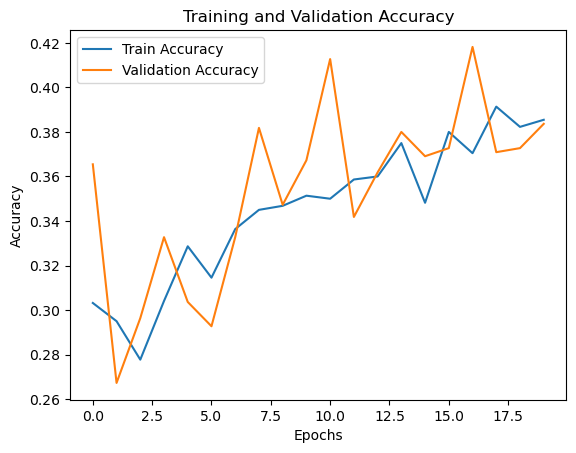

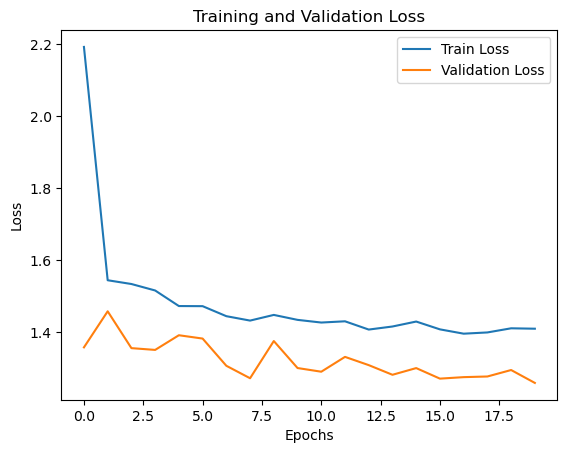

In [ ]:
# Plot Training & Validation Accuracy and Loss Curves

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [ ]:
# Print model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 220, 220, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 220, 220, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 110, 110, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 106, 106, 64)   │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 106, 106, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 179776)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 100)            │    17,977,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,095,705 (206.36 MB)

 Trainable params: 18,031,901 (68.79 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 36,063,804 (137.57 MB)

### RESNET50

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

# Load the ResNet50 model pre-trained on ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers to retain the pre-trained knowledge
for layer in base_model.layers:
    layer.trainable = False

# Create the custom model
model = Sequential([
    base_model,
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(train_generator.num_classes, activation='softmax')  # Output layer (5 classes)
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])



In [ ]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,  # You can increase the number of epochs as needed
    class_weight=class_weights_dict  # Using class weights to handle class imbalance
)


Epoch 1/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.2320 - loss: 2.8121 - val_accuracy: 0.2036 - val_loss: 1.5622
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.2674 - loss: 1.6179 - val_accuracy: 0.5473 - val_loss: 1.4370
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.3197 - loss: 1.5832 - val_accuracy: 0.3909 - val_loss: 1.4812
Epoch 4/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.3610 - loss: 1.5267 - val_accuracy: 0.5618 - val_loss: 1.3953
Epoch 5/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.3770 - loss: 1.5125 - val_accuracy: 0.5436 - val_loss: 1.4156
Epoch 6/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.3767 - loss: 1.4961 - val_accuracy: 0.3982 - val_loss: 1.3263
Epoch 7/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.3744 - loss: 1.5451 - val_accuracy: 0.5364 - val_loss: 1.3022
Epoch 8/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.3671 - loss: 1.5234 - val_accuracy: 0.4073 - v

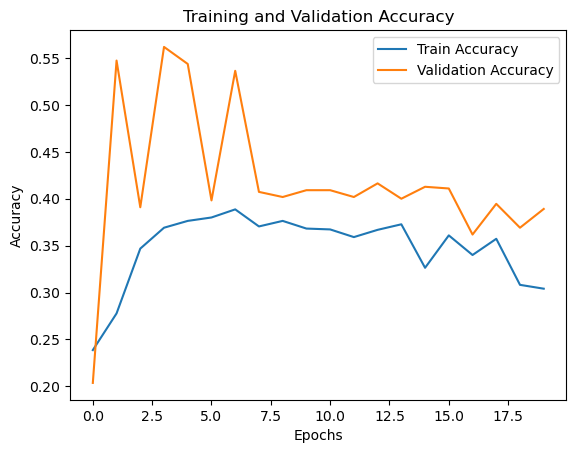

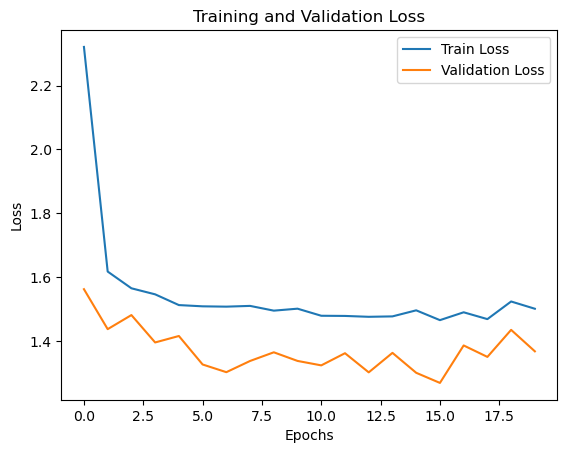

In [ ]:
# Plot Training & Validation Accuracy and Loss Curves

# Accuracy plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │   102,761,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │         2,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 333,454,225 (1.24 GB)

 Trainable params: 103,288,837 (394.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 206,577,676 (788.03 MB)

### GoogleNet (InceptionV3)

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


In [ ]:
def build_inceptionv3_model(input_shape=(224, 224, 3), num_classes=5):
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model
    base_model.trainable = False

    # Custom top layers
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),  # Instead of Flatten, using GAP reduces overfitting and works well with InceptionV3
        Dense(1024, activation='relu'),
        Dropout(0.5),  # Dropout to reduce overfitting
        Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Instantiate the model
model = build_inceptionv3_model()

In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    class_weight=class_weights_dict
)



Epoch 1/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.3777 - loss: 2.2335 - val_accuracy: 0.3418 - val_loss: 1.3783
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.4473 - loss: 1.4022 - val_accuracy: 0.4891 - val_loss: 1.0776
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.5069 - loss: 1.2310 - val_accuracy: 0.6255 - val_loss: 0.9995
Epoch 4/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.5347 - loss: 1.2018 - val_accuracy: 0.6364 - val_loss: 0.9368
Epoch 5/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.5358 - loss: 1.2008 - val_accuracy: 0.6273 - val_loss: 0.9395
Epoch 6/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.5240 - loss: 1.2144 - val_accuracy: 0.5764 - val_loss: 0.9621
Epoch 7/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.5256 - loss: 1.2089 - val_accuracy: 0.5091 - val_loss: 1.0250
Epoch 8/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - accuracy: 0.5006 - loss: 1.2244 - val_accuracy: 0.6309 - val_loss:

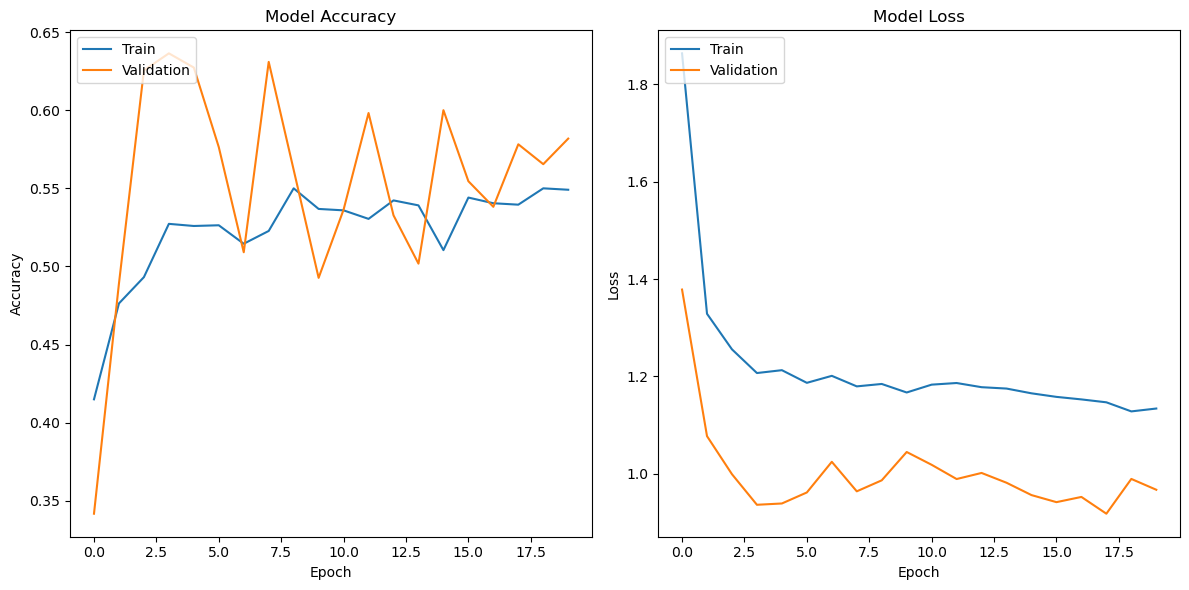

In [ ]:
def plot_performance_curves(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Call the function to plot performance curves
plot_performance_curves(history)



In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,112,689 (107.24 MB)

 Trainable params: 2,103,301 (8.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

 Optimizer params: 4,206,604 (16.05 MB)

### VGG

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load the VGG16 model with pre-trained weights from ImageNet, excluding the top layers
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base VGG16 layers to avoid re-training them
for layer in vgg16_base.layers:
    layer.trainable = False

# Add custom layers on top of the pre-trained VGG16 model
x = vgg16_base.output
x = Flatten()(x)  # Flatten the output of the convolutional layers
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Dropout to prevent overfitting
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(5, activation='softmax')(x)  # Assuming 5 classes for DR classification

# Create the model
model_vgg16 = Model(inputs=vgg16_base.input, outputs=output_layer)

# Compile the model
model_vgg16.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])




In [ ]:
# Training the VGG16 model
history_vgg16 = model_vgg16.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,  # You can adjust the number of epochs based on performance
    class_weight=class_weights_dict  # If class imbalance is present
)



Epoch 1/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 411s 6s/step - accuracy: 0.3212 - loss: 1.7623 - val_accuracy: 0.4927 - val_loss: 1.1810
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 443s 6s/step - accuracy: 0.4179 - loss: 1.4876 - val_accuracy: 0.5764 - val_loss: 1.1888
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 447s 6s/step - accuracy: 0.4136 - loss: 1.4547 - val_accuracy: 0.4618 - val_loss: 1.2045
Epoch 4/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 453s 7s/step - accuracy: 0.4005 - loss: 1.4672 - val_accuracy: 0.4455 - val_loss: 1.2077
Epoch 5/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 447s 6s/step - accuracy: 0.4178 - loss: 1.4362 - val_accuracy: 0.5036 - val_loss: 1.1741
Epoch 6/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 407s 6s/step - accuracy: 0.4823 - loss: 1.3684 - val_accuracy: 0.4873 - val_loss: 1.1678
Epoch 7/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 400s 6s/step - accuracy: 0.4537 - loss: 1.3639 - val_accuracy: 0.4636 - val_loss: 1.1500
Epoch 8/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 437s 6s/step - accuracy: 0.4489 - loss: 1.3679 - val_accuracy: 0.6218 - v

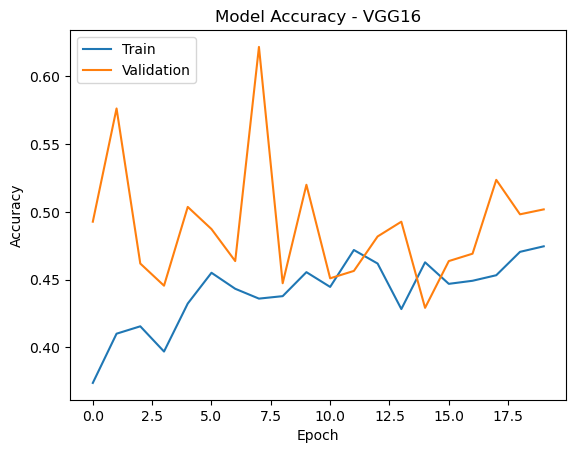

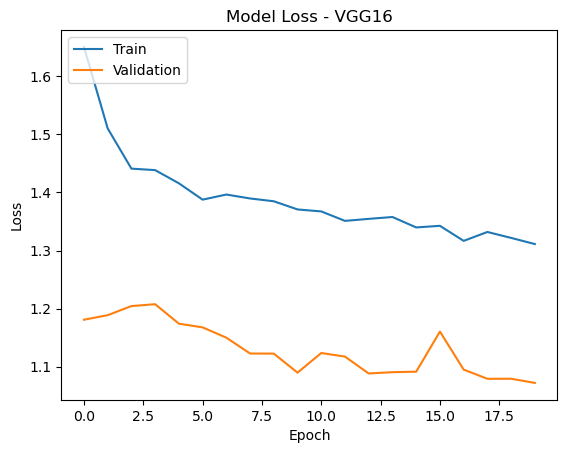

In [ ]:
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title('Model Accuracy - VGG16')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_vgg16.history['loss'])
plt.plot(history_vgg16.history['val_loss'])
plt.title('Model Loss - VGG16')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
# Display the model summary
model_vgg16.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │    12,845,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │         1,28

 Total params: 53,649,233 (204.66 MB)

 Trainable params: 12,978,181 (49.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 25,956,364 (99.02 MB)

###  Densenet Model

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Function to create DenseNet model
def create_densenet_model(input_shape, num_classes):
    # Load the DenseNet121 model pre-trained on ImageNet
    base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=input_shape)

    # Add custom layers on top of DenseNet
    inputs = Input(shape=input_shape)
    x = base_model(inputs)
    x = GlobalAveragePooling2D()(x)

    # Add a fully connected layer for classification
    outputs = Dense(num_classes, activation='softmax')(x)

    # Build and compile the model
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    return model


In [ ]:
# Create the DenseNet model
input_shape = (224, 224, 3)  # Example input size (adjust based on your dataset)
num_classes = len(train_generator.class_indices)  # Set the number of output classes
densenet_model = create_densenet_model(input_shape, num_classes)

# Train the DenseNet model
history_densenet = densenet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,  # Adjust the number of epochs based on your needs
    class_weight=class_weights_dict,  # Use computed class weights for imbalanced data
    verbose=1
)

densenet_model.save('densenet_model.keras')


Epoch 1/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 452s 6s/step - accuracy: 0.3811 - loss: 1.5972 - val_accuracy: 0.0691 - val_loss: 286.7822
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 396s 6s/step - accuracy: 0.5660 - loss: 1.1069 - val_accuracy: 0.3418 - val_loss: 1.5742
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 398s 6s/step - accuracy: 0.5632 - loss: 1.1294 - val_accuracy: 0.5418 - val_loss: 1.3719
Epoch 4/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 401s 6s/step - accuracy: 0.6105 - loss: 1.0766 - val_accuracy: 0.4964 - val_loss: 1.5843
Epoch 5/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 404s 6s/step - accuracy: 0.6203 - loss: 1.0438 - val_accuracy: 0.6309 - val_loss: 1.0272
Epoch 6/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 402s 6s/step - accuracy: 0.6195 - loss: 0.9406 - val_accuracy: 0.4636 - val_loss: 1.9868
Epoch 7/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 407s 6s/step - accuracy: 0.6372 - loss: 1.0692 - val_accuracy: 0.4873 - val_loss: 1.2641
Epoch 8/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 430s 6s/step - accuracy: 0.6222 - loss: 0.9792 - val_accuracy: 0.3636 -

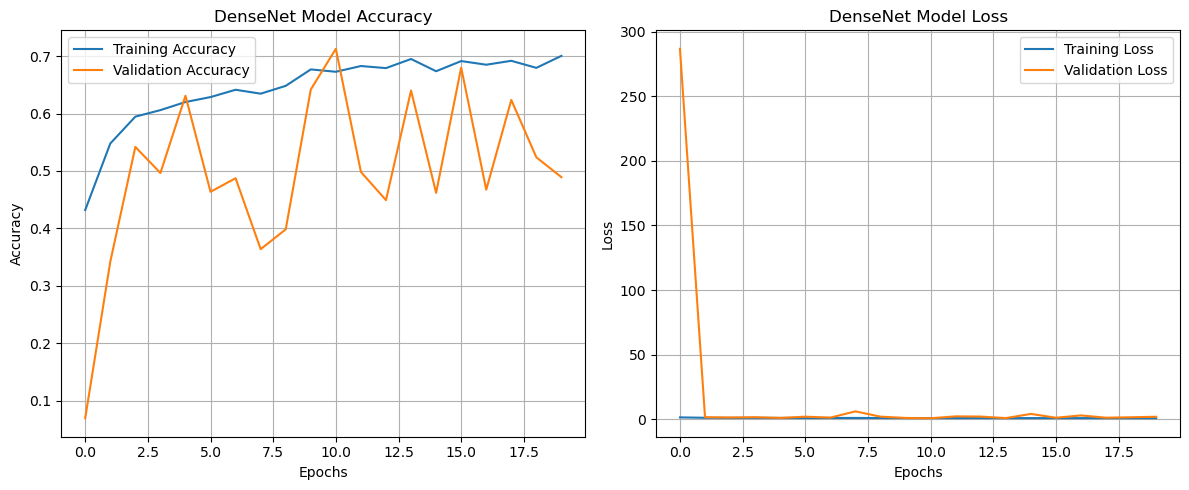

In [ ]:
import matplotlib.pyplot as plt

# Function to plot accuracy and loss curves
def plot_performance(history, model_name="Model"):
    # Accuracy plot
    plt.figure(figsize=(12, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    # Show the plots
    plt.tight_layout()
    plt.show()

# Call this function after training your model, passing in the training history
plot_performance(history_densenet, model_name="DenseNet Model")


In [ ]:
densenet_model.summary()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 5)              │         5,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,960,593 (79.96 MB)

 Trainable params: 6,958,981 (26.55 MB)

 Non-trainable params: 83,648 (326.75 KB)

 Optimizer params: 13,917,964 (53.09 MB)

### ZFNet

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam

# Define ZFNet Model
def create_zfnet_model(input_shape, num_classes):
    model = Sequential([
        # First Convolutional Layer
        Conv2D(96, (7, 7), strides=2, padding='valid', input_shape=input_shape),
        Activation('relu'),
        MaxPooling2D(pool_size=(3, 3), strides=2),

        # Second Convolutional Layer
        Conv2D(256, (5, 5), strides=2, padding='valid'),
        Activation('relu'),
        MaxPooling2D(pool_size=(3, 3), strides=2),

        # Third Convolutional Layer
        Conv2D(384, (3, 3), padding='same'),
        Activation('relu'),

        # Fourth Convolutional Layer
        Conv2D(384, (3, 3), padding='same'),
        Activation('relu'),

        # Fifth Convolutional Layer
        Conv2D(256, (3, 3), strides=1, padding='same'),
        Activation('relu'),
        MaxPooling2D(pool_size=(3, 3), strides=2),

        # Fully Connected Layer
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.5),

        # Output Layer
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Set input shape and number of classes
input_shape = (224, 224, 3)
num_classes = len(train_generator.class_indices)

# Create the ZFNet model
zfnet_model = create_zfnet_model(input_shape, num_classes)


# Train the ZFNet model
history_zfnet = zfnet_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,  # Adjust the number of epochs based on your needs
    class_weight=class_weights_dict,  # Use computed class weights for imbalanced data
    verbose=1
)

# Save the ZFNet model
zfnet_model.save('zfnet_model.h5')


Epoch 1/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - accuracy: 0.1719 - loss: 1.7563 - val_accuracy: 0.1055 - val_loss: 1.6207
Epoch 2/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.1449 - loss: 1.5522 - val_accuracy: 0.2218 - val_loss: 1.5039
Epoch 3/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.2300 - loss: 1.5917 - val_accuracy: 0.0691 - val_loss: 1.6407
Epoch 4/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.0845 - loss: 1.6434 - val_accuracy: 0.0709 - val_loss: 1.6129
Epoch 5/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.2350 - loss: 1.7196 - val_accuracy: 0.0691 - val_loss: 1.6336
Epoch 6/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.0767 - loss: 1.6129 - val_accuracy: 0.1055 - val_loss: 1.6119
Epoch 7/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.1553 - loss: 1.6361 - val_accuracy: 0.1055 - val_loss: 1.6069
Epoch 8/20
69/69 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - accuracy: 0.1974 - loss: 1.6020 - val_accuracy: 0.3636 - val_loss

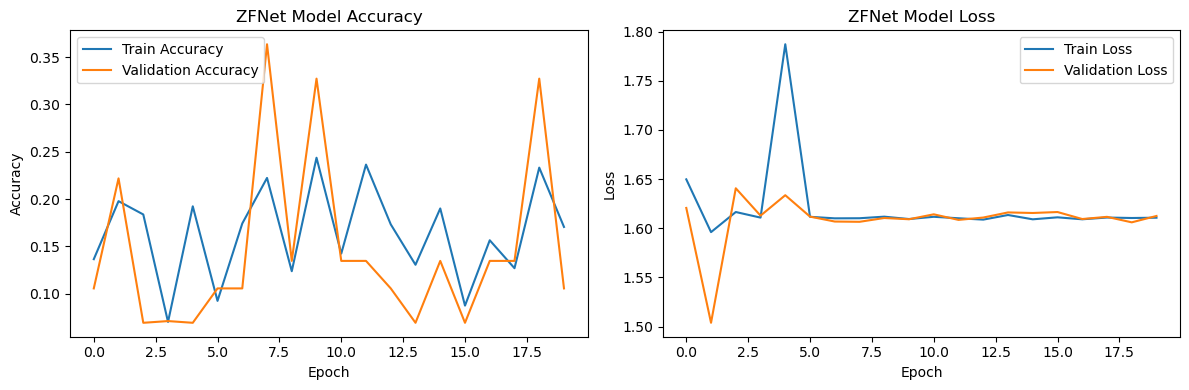

In [ ]:
import matplotlib.pyplot as plt

# Function to plot accuracy and loss curves
def plot_performance(history, model_name="Model"):
    # Accuracy plot
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')

    plt.tight_layout()
    plt.show()

# Now plot the performance for ZFNet
plot_performance(history_zfnet, model_name="ZFNet Model")


In [ ]:

# Print model summary
zfnet_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_101 (Conv2D)             │ (None, 109, 109, 96)   │        14,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_101 (Activation)     │ (None, 109, 109, 96)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 54, 54, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_102 (Conv2D)             │ (None, 25, 25, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_102 (Activation)     │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_103 (Conv2D)             │ (None, 12, 12, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_103 (Activation)     │ (None, 12, 12, 384)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_104 (Conv2D)             │ (None, 12, 12, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_104 (Activation)     │ (None, 12, 12, 384)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_105 (Conv2D)             │ (None, 12, 12, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_105 (Activation)     │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 4096)           │    26,218,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 5)              │        20,485 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 89,896,337 (342.93 MB)

 Trainable params: 29,965,445 (114.31 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 59,930,892 (228.62 MB)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# Define CNN Model
model_cnn = create_cnn_model(num_classes)

# Define ResNet Model
model_resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Modify the rest of ResNet model as done previously

# Define InceptionV3 Model (GoogLeNet)
model_googlenet = build_inceptionv3_model(input_shape=(224, 224, 3), num_classes=num_classes)

# Define VGG16 Model
model_vgg16 = Model(inputs=vgg16_base.input, outputs=output_layer)  # As already done

# Define DenseNet Model
model_densenet = create_densenet_model(input_shape=(224, 224, 3), num_classes=num_classes)

# Define ZFNet Model
model_zfnet = create_zfnet_model(input_shape=(224, 224, 3), num_classes=num_classes)



In [ ]:
# Predict using each model
y_true = validation_generator.classes

# Predict for CNN model
y_pred_cnn = np.argmax(model_cnn.predict(validation_generator), axis=-1)

# Predict for ResNet model
y_pred_resnet = np.argmax(model_resnet.predict(validation_generator), axis=-1)

# Predict for InceptionV3 (GoogLeNet) model
y_pred_googlenet = np.argmax(model_googlenet.predict(validation_generator), axis=-1)

# Predict for VGG16 model
y_pred_vgg16 = np.argmax(model_vgg16.predict(validation_generator), axis=-1)

# Predict for DenseNet model
y_pred_densenet = np.argmax(model_densenet.predict(validation_generator), axis=-1)

# Predict for ZFNet model
y_pred_zfnet = np.argmax(model_zfnet.predict(validation_generator), axis=-1)


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 259ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 17s 915ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 15s 760ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 64s 4s/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 399ms/step


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 265ms/step


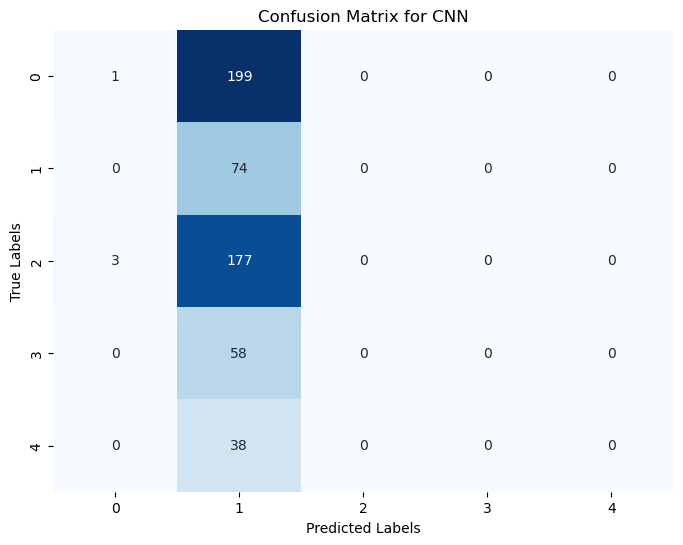

Classification Report for CNN:

                precision    recall  f1-score   support

       Healthy       0.25      0.01      0.01       200
       Mild DR       0.14      1.00      0.24        74
   Moderate DR       0.00      0.00      0.00       180
Proliferate DR       0.00      0.00      0.00        58
     Severe DR       0.00      0.00      0.00        38

      accuracy                           0.14       550
     macro avg       0.08      0.20      0.05       550
  weighted avg       0.11      0.14      0.04       550

18/18 ━━━━━━━━━━━━━━━━━━━━ 12s 629ms/step


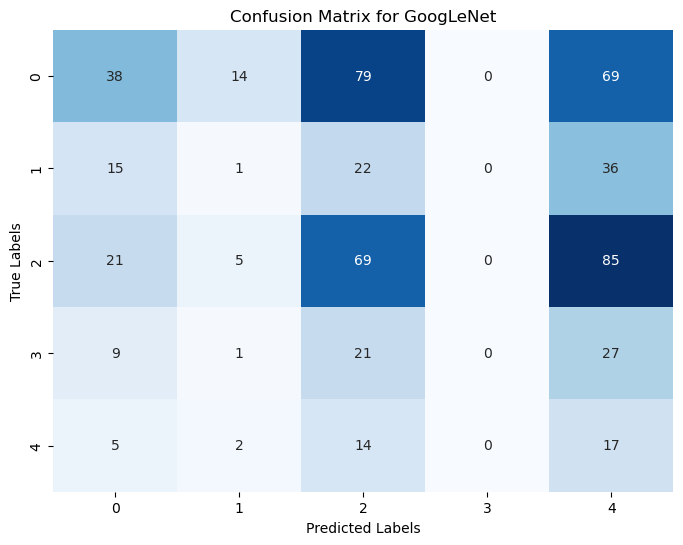

Classification Report for GoogLeNet:

                precision    recall  f1-score   support

       Healthy       0.43      0.19      0.26       200
       Mild DR       0.04      0.01      0.02        74
   Moderate DR       0.34      0.38      0.36       180
Proliferate DR       0.00      0.00      0.00        58
     Severe DR       0.07      0.45      0.12        38

      accuracy                           0.23       550
     macro avg       0.18      0.21      0.15       550
  weighted avg       0.28      0.23      0.22       550

18/18 ━━━━━━━━━━━━━━━━━━━━ 60s 3s/step


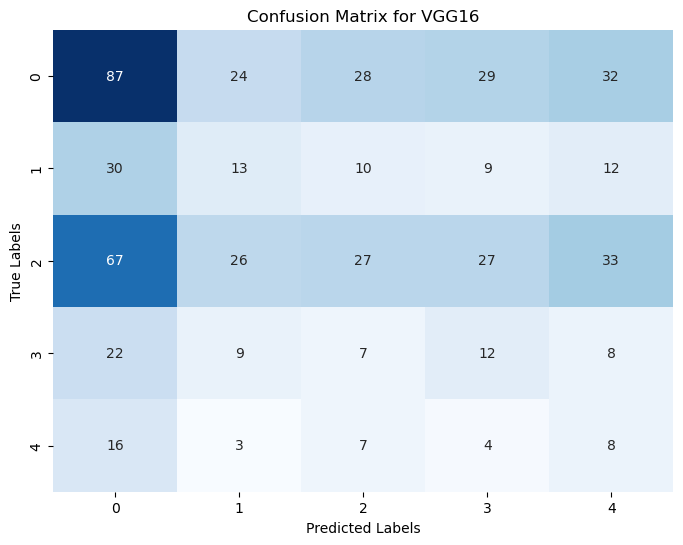

Classification Report for VGG16:

                precision    recall  f1-score   support

       Healthy       0.39      0.43      0.41       200
       Mild DR       0.17      0.18      0.17        74
   Moderate DR       0.34      0.15      0.21       180
Proliferate DR       0.15      0.21      0.17        58
     Severe DR       0.09      0.21      0.12        38

      accuracy                           0.27       550
     macro avg       0.23      0.24      0.22       550
  weighted avg       0.30      0.27      0.27       550

18/18 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step


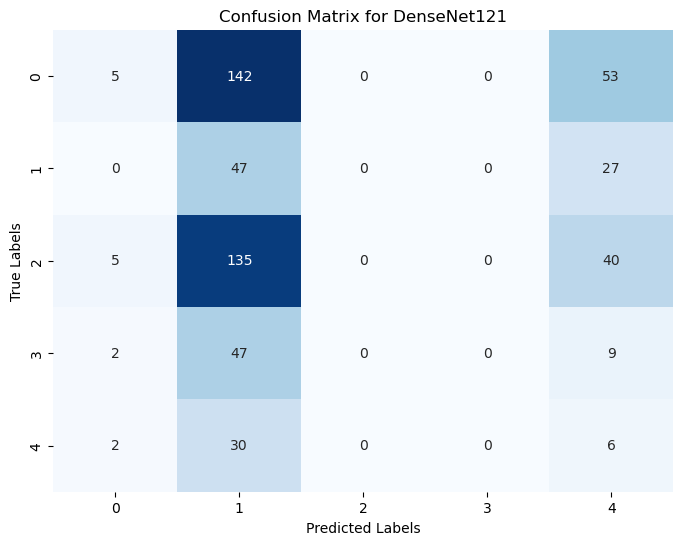

Classification Report for DenseNet121:

                precision    recall  f1-score   support

       Healthy       0.36      0.03      0.05       200
       Mild DR       0.12      0.64      0.20        74
   Moderate DR       0.00      0.00      0.00       180
Proliferate DR       0.00      0.00      0.00        58
     Severe DR       0.04      0.16      0.07        38

      accuracy                           0.11       550
     macro avg       0.10      0.16      0.06       550
  weighted avg       0.15      0.11      0.05       550

18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 380ms/step


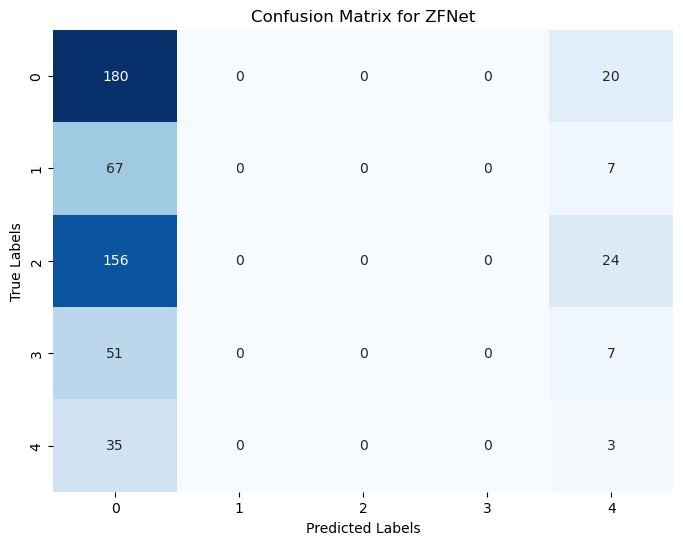

Classification Report for ZFNet:

                precision    recall  f1-score   support

       Healthy       0.37      0.90      0.52       200
       Mild DR       0.00      0.00      0.00        74
   Moderate DR       0.00      0.00      0.00       180
Proliferate DR       0.00      0.00      0.00        58
     Severe DR       0.05      0.08      0.06        38

      accuracy                           0.33       550
     macro avg       0.08      0.20      0.12       550
  weighted avg       0.14      0.33      0.19       550



In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot the confusion matrix
def plot_confusion_matrix(cm, model_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix for {model_name}")
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

# Function to calculate and plot confusion matrix for a given model
def evaluate_model(model, model_name):
    # Get true labels (these should be integer class labels)
    y_true = validation_generator.classes

    # Ensure true labels are a numpy array
    y_true = np.array(y_true)

    # Get predicted probabilities and convert to predicted class labels
    y_pred_prob = model.predict(validation_generator)

    # Convert probabilities to predicted labels
    y_pred = np.argmax(y_pred_prob, axis=-1)

    # Ensure predicted labels are numpy arrays
    y_pred = np.array(y_pred)

    # Ensure y_true and y_pred are arrays of the same shape and type
    assert y_true.shape == y_pred.shape, "Mismatch in shapes of y_true and y_pred"

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plot_confusion_matrix(cm, model_name)

    # Print precision, recall, and F1-score
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(y_true, y_pred, target_names=list(validation_generator.class_indices.keys()), zero_division=0))

# Evaluate CNN Model
evaluate_model(model_cnn, "CNN")

# Evaluate GoogLeNet (InceptionV3) Model
evaluate_model(model_googlenet, "GoogLeNet")

# Evaluate VGG16 Model
evaluate_model(model_vgg16, "VGG16")

# Evaluate DenseNet Model
evaluate_model(model_densenet, "DenseNet121")

# Evaluate ZFNet Model
evaluate_model(model_zfnet, "ZFNet")


In [ ]:
!pip install streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 464.4 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 658.1/658.1 kB 483.8 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 611.3 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 504.9 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 596.0 kB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 739.0 kB/s eta 0:00:00a 0:00:01
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [ ]:
!jupyter nbconvert --to script Diabetic_Retinopathy_MINI_PROJECT-Copy2.ipynb


[NbConvertApp] Converting notebook Diabetic_Retinopathy_MINI_PROJECT-Copy2.ipynb to script
[NbConvertApp] Writing 21791 bytes to Diabetic_Retinopathy_MINI_PROJECT-Copy2.py
